In [1]:
import pandas as pd
import re
from math import isnan    
import numpy as np
import string
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

In [2]:
data=pd.read_csv('weibo_train_data.txt',sep='\t',header=None)
data.columns=['user_id','weibo_id','time','repost','comments','likes','text']
data.head()

,user_id,weibo_id,time,repost,comments,likes,text
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0,0,0,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,0,0,0,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,2015-03-31 13:58:06,0,0,0,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,2015-06-11 20:39:57,0,4,3,看点不能说的，你们都懂[笑cry]
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,2015-03-10 18:02:38,0,0,0,111多张


# 一、 微博的用户特征 by 刘安蕾

1. 历史数据的 range（最大值和最小值）, 平均值和方差，大于平均值的次数。
2. 在训练集中出现的次数（发博频率） （需要补充）
3. 在训练集中收获转发的最高次数（估计粉丝量水平） （需要补充）
4. 历史评论中位数/转发中位数（账号类型）（没懂什么意思）

In [7]:
def process_max(data):
    ###求训练集中出现的次数
    df_processnum=data.groupby('user_id').agg({'user_id':np.sum})
    df_processnum.columns=['number_in_train']
    df_processnum.reset_index(inplace = True)
    data =pd.merge(data, df_processnum, on=['user_id']).fillna(0)
    ###求最大值
    df_processmax=data.groupby('user_id').agg({'repost':np.max,'comments':np.max,'likes':np.max})
#    print (df_processmax.columns)
    df_processmax.columns=['forward_max','comment_max','like_max']
    df_processmax.reset_index(inplace = True)
    data =pd.merge(data, df_processmax, on=['user_id']).fillna(0)
    ###求最小值
    df_processmin=data.groupby('user_id').agg({'repost':np.min,'comments':np.min,'likes':np.min})
    df_processmin.columns=['forward_min','comment_min','like_min']
    df_processmin.reset_index(inplace = True)
    data =pd.merge(data, df_processmin, on=['user_id']).fillna(0)
    ####求平均值
    df_processmean=data.groupby('user_id').agg({'repost':np.mean,'comments':np.mean,'likes':np.mean})
    df_processmean.columns=['forward_mean','comment_mean','like_mean']
    df_processmean.reset_index(inplace = True)
    data =pd.merge(data, df_processmean, on=['user_id']).fillna(0)
#####求某一用户发的微博互动大于平均值的概率
    daa=pd.DataFrame({'user_id':data['user_id'].value_counts()})
    daa.reset_index(inplace=True)
    daa.columns=['user_id','count']
    ###统计大于平均值的发博次数
    forward_ave=np.mean(data['repost'])
    comment_ave=np.mean(data['comments'])
    like_ave=np.mean(data['likes'])
#    print (forward_ave,comment_ave,like_ave)
    data['forward_judge']=data['repost'].apply(lambda x:1 if x>forward_ave else 0)
    data['comment_judge']=data['comments'].apply(lambda x:1 if x>comment_ave else 0)
    data['like_judge']=data['likes'].apply(lambda x:1 if x>like_ave else 0)
    more_ave=data.groupby('user_id').agg({'forward_judge':np.sum,'comment_judge':np.sum,'like_judge':np.sum})
    more_ave.columns=['forward_more_ave','comment_more_ave','like_more_ave']
    more_ave.reset_index(inplace = True)
    data.drop(['forward_judge','comment_judge','like_judge'],axis=1, inplace=True)
    daa =pd.merge(more_ave, daa, on=['user_id'])
    daa['forward_more_ave_pr']=daa['forward_more_ave']/daa['count']
    daa['comment_more_ave_pr']=daa['comment_more_ave']/daa['count']
    daa['like_more_ave_pr']=daa['like_more_ave']/daa['count']
    daa.drop(['forward_more_ave','comment_more_ave','like_more_ave','count'],axis=1, inplace=True)
    data =pd.merge(data, daa, on=['user_id']).fillna(0)  
    data['max_f/l']=pd.DataFrame({'max_f/l':list(map(lambda x, y: x/y if y>0 else 0, data['forward_max'],data['like_max']))})
    data['max_c/l']=pd.DataFrame({'max_c/l':list(map(lambda x, y: x/y if y>0 else 0, data['comment_max'],data['like_max']))})
    data['min_f/l']=pd.DataFrame({'min_f/l':list(map(lambda x, y: x/y if y>0 else 0, data['forward_min'],data['like_min']))})
    data['min_c/l']=pd.DataFrame({'min_c/l':list(map(lambda x, y: x/y if y>0 else 0, data['comment_min'],data['like_min']))})
    data['mean_f/l']=pd.DataFrame({'mean_f/l':list(map(lambda x, y: x/y if y>0 else 0, data['forward_mean'],data['like_mean']))})
    data['mean_c/l']=pd.DataFrame({'mean_c/l':list(map(lambda x, y: x/y if y>0 else 0, data['comment_mean'],data['like_mean']))}) 
    return data

data=process_max(data)
data.head()

,user_id,weibo_id,time,repost,comments,likes,text,number_in_train,forward_max,comment_max,...,like_mean,forward_more_ave_pr,comment_more_ave_pr,like_more_ave_pr,max_f/l,max_c/l,min_f/l,min_c/l,mean_f/l,mean_c/l
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0.0,0.0,0.0,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114.0,48.0,...,0.061465,0.020924,0.024412,0.001744,22.8,9.6,0.0,0.0,17.085106,5.680851
1,d38e9bed5d98110dc2489d0d1cac3c2a,00755196c77936bf44656ada98291c59,2015-07-13 19:24:50,0.0,0.0,0.0,想开了就是幸福，想不开就是痛苦…http://t.cn/RLqzYa1,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114.0,48.0,...,0.061465,0.020924,0.024412,0.001744,22.8,9.6,0.0,0.0,17.085106,5.680851
2,d38e9bed5d98110dc2489d0d1cac3c2a,4fedf3888b1e16592f0e0bdc8b393845,2015-03-14 21:22:57,0.0,0.0,0.0,300419浩丰科技#股票##股神##股市##炒股##财经##理财##投资# 股票庄家，要求...,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114.0,48.0,...,0.061465,0.020924,0.024412,0.001744,22.8,9.6,0.0,0.0,17.085106,5.680851
3,d38e9bed5d98110dc2489d0d1cac3c2a,91be0b8612265aae32725cd4fa80b222,2015-06-18 16:25:36,0.0,0.0,0.0,女性被人占便宜从来不生气，是什么心态？http://t.cn/R2n2pRz,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114.0,48.0,...,0.061465,0.020924,0.024412,0.001744,22.8,9.6,0.0,0.0,17.085106,5.680851
4,d38e9bed5d98110dc2489d0d1cac3c2a,bd2af99ecf1298f5539f0ddfcdd3ed64,2015-02-23 17:35:31,0.0,0.0,0.0,网宿科技(sz300017)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114.0,48.0,...,0.061465,0.020924,0.024412,0.001744,22.8,9.6,0.0,0.0,17.085106,5.680851


# 二、用户的时间特征 by 武妍戎

1. 是否周中，是否周末  
2. 是否节假日  
3. 发文时间段（需要结合数据再最后确定）  
4. 工作日与节假日可能存在交互效应（作息不同）  
5. 在训练集中出现次数 / 第一条为微博到最近一条微博时间(不懂什么意思)  

In [4]:
def process_time(data):
    data['time_date']=data['time'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").date())
###求星期几
    data['time_weekday']=data['time_date'].apply(lambda x: x.weekday())+1
    data['time_weekend1']=((data['time_weekday']==6))
    data['time_weekend2']=((data['time_weekday']==7))
    #data['time_weekend']=(data.loc[1,'time_weekend1'])or(data.loc[1,'time_weekend2'])
    ###计算是否为周末
    data['time_weekend']=pd.DataFrame({'time_weekend':list(map(lambda x, y: 1 if x|y else 0, data['time_weekend1'],data['time_weekend2']))})
###求发博时间段，由于作息不同，故时间段有交叉
    data['time_hour']=data['time'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").hour)
    data.loc[data.apply(lambda data:(data['time_hour']>-1)and(data['time_hour']<6), axis=1), 'panduan']=1   
    data.loc[data.apply(lambda data:(data['time_hour']>5)and(data['time_hour']<12), axis=1), 'panduan']=2
    data.loc[data.apply(lambda data:(data['time_hour']>11)and(data['time_hour']<18), axis=1), 'panduan']=3 
    data.loc[data.apply(lambda data:(data['time_hour']>17)and(data['time_hour']<24), axis=1), 'panduan']=4
    data.drop(['time_date','time_weekend1','time_weekend2'],axis=1, inplace=True)
    return data

data=process_time(data)
data.head()

,user_id,weibo_id,time,repost,comments,likes,text,number_in_train,forward_max,comment_max,...,max_f/l,max_c/l,min_f/l,min_c/l,mean_f/l,mean_c/l,time_weekday,time_weekend,time_hour,panduan
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0,0,0,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114,48,...,22.8,9.6,0.0,0.0,17.085106,5.680851,1,0,17,3.0
1,d38e9bed5d98110dc2489d0d1cac3c2a,00755196c77936bf44656ada98291c59,2015-07-13 19:24:50,0,0,0,想开了就是幸福，想不开就是痛苦…http://t.cn/RLqzYa1,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114,48,...,22.8,9.6,0.0,0.0,17.085106,5.680851,1,0,19,4.0
2,d38e9bed5d98110dc2489d0d1cac3c2a,4fedf3888b1e16592f0e0bdc8b393845,2015-03-14 21:22:57,0,0,0,300419浩丰科技#股票##股神##股市##炒股##财经##理财##投资# 股票庄家，要求...,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114,48,...,22.8,9.6,0.0,0.0,17.085106,5.680851,6,1,21,4.0
3,d38e9bed5d98110dc2489d0d1cac3c2a,91be0b8612265aae32725cd4fa80b222,2015-06-18 16:25:36,0,0,0,女性被人占便宜从来不生气，是什么心态？http://t.cn/R2n2pRz,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114,48,...,22.8,9.6,0.0,0.0,17.085106,5.680851,4,0,16,3.0
4,d38e9bed5d98110dc2489d0d1cac3c2a,bd2af99ecf1298f5539f0ddfcdd3ed64,2015-02-23 17:35:31,0,0,0,网宿科技(sz300017)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,d38e9bed5d98110dc2489d0d1cac3c2ad38e9bed5d9811...,114,48,...,22.8,9.6,0.0,0.0,17.085106,5.680851,1,0,17,3.0


# 三、微博文本特征 by 陈永乔

In [5]:
#a. 微博原始长度
f=lambda x:len(str(x))
data['length_all']=data['text'].map(f)

In [6]:
#a. 微博中文长度
def count_chinese(text):
    text=str(text)
    num=0
    for s in text:
        if '\u4e00' <= s <= '\u9fff':
            num+=1
    return num
data['length_chinese']=data['text'].map(count_chinese)

In [7]:
#b. 是否为英文内容，字数一般以上是英文字母，则该微博是英文
def is_en(text):
    text=str(text)
    num=0
    for s in text:
        if s in string.ascii_letters:
            num+=1
    if num>len(text)*0.5:
        return 1
    else:
        return 0
    
data['english']=data['text'].map(is_en)

In [8]:
#b. 是否为非中文内容
def Non_ch(text):
    text=str(text)
    num=0
    for s in text:
        if '\u4e00' <= s <= '\u9fff':
            num+=1
    if num==0:
        return 1
    else:
        return 0
data['non_ch']=data['text'].map(Non_ch)

In [9]:
#d.是否为分享
def is_sharing(text):
    text=str(text)
    if re.findall(r'分享',text,re.I):
        return 1
    if re.findall(r'推荐',text,re.I):
        return 1
    return 0
data['sharing']=data['text'].map(is_sharing)

In [10]:
#e. 是否为回复自动发博(文本中包含'我...了'和'@'或网页链接)
def is_auto(text):
    text_1=str(text)
    text=np.array(list(str(text)))
    flag_1=0  #是否包含'我...了'
    flag_2=0  #是否包含'@'
    flag_3=0  #是否包含http
    if re.findall(r'我.+了',text_1,re.I):
        flag_1=1   
    if re.findall(r'@',text_1,re.I):
        flag_2=1    
    if re.findall(r'http',text_1,re.I):
        flag_3=1
    if flag_1*(flag_2+flag_3)>=1:
        return 1
    else:
        return 0
data['auto']=data['text'].map(is_auto)

In [11]:
#f. 是否为互动内容（是否包含'//'，但要考虑网页链接中的'//'）
def is_interaction(text):
    text=str(text)
    num_1=len(re.findall(r'//',text,re.I))
    num_2=len(re.findall(r'http',text,re.I))
    if num_1>num_2:
        return 1
    else:
        return 0
data['interaction']=data['text'].map(is_interaction)

In [12]:
#g. 是否包含书名号《》
def is_book(text):
    text=str(text)
    if re.findall(r'《.+》',text,re.I):
        return 1
    else:
        return 0
data['book']=data['text'].map(is_book)

In [13]:
#h. 是否包含@
def is_mention(text):
    text=str(text)
    if re.findall(r'@',text,re.I):
        return 1
    else:
        return 0
data['mention']=data['text'].map(is_mention)

In [14]:
#i. 是否包含投票
def is_vote(text):
    text=str(text)
    if re.findall(r'投票',text,re.I):
        return 1
    else:
        return 0
data['vote']=data['text'].map(is_vote)

In [15]:
#j. 是否包含抽奖
def is_lottery(text):
    text=str(text)
    if re.findall(r'抽[奖到中]',text,re.I):
        return 1
    if re.findall(r'[奖礼]品',text,re.I):
        return 1
    if re.findall(r'[好大]礼',text,re.I):
        return 1
    if re.findall(r'[赢领]取',text,re.I):
        return 1
    return 0
data['lottery']=data['text'].map(is_lottery)

In [16]:
#k. 是否包含表情
def is_emoji(text):
    text=str(text)
    if re.findall(r'\[.+\]',text,re.I):
        return 1
    else:
        return 0
data['emoji']=data['text'].map(is_emoji)

In [17]:
#L.是否包含视频
def is_video(text):
    text=str(text)
    if re.findall(r'【视频',text,re.I):
        return 1
    return 0
data['video']=data['text'].map(is_video)

In [18]:
#M.是否包含链接
def is_http(text):
    text=str(text)
    if re.findall(r'http',text,re.I):
        return 1
    return 0
data['http']=data['text'].map(is_http)

# 四、微博文本特征 by 欧阳

In [19]:
# n. 是否存在第三方平台互动消息（“我在#xxx”）
data['app'] = data.text.apply(lambda x: 1 if '我' in str(x) else 0) # str to convert string in numbers into strings

In [20]:
# o. 是否包含【】/是否有标题（很可能是新闻）
data['title'] = data.text.apply(lambda x: 1 if str(x)[0] == '【' else 0) 

In [21]:
# q. 是否包含广告
ad_keywords = ['天猫', '淘宝', '京东','当当','唯品会','唯品会','红包','购物券', '折扣', '优惠']
data['ad'] = data.text.apply(lambda x: 1 if any( keyword in str(x) for keyword in ad_keywords) else 0) # list generator

In [22]:
# r. 是否包含百度热词
baidu_hot_words = ['2015阅兵', '奔跑吧兄弟', '花干骨', 'duang', 'DUANG', '毕福剑', '完美世界', '清华大学', '九寨沟', '天津爆炸', '快乐大本营', \
                   '校花的贴身高手', '车震', '金星', '大主宰', '武汉大学', '泰山', '全面开放二孩政策', 'running man','Running Man','Running man',\
                   'RUNNING MAN', '盗墓笔记', '萌萌哒', '王思聪', '淘宝', '厦门大学', '颐和园', '优衣库事件', '最强大脑', '何以笙箫默', '然并卵', \
                   '叶良辰', '百度', '北京大学', '故宫', '毕福剑违纪', '极限挑战', '斗鱼', '有钱就是任性', '昆凌', '我欲封天', '中山大学', '华山', \
                   'a股保卫战','A股保卫战', '欢乐喜剧人', '琅琊榜', '不做死就不会死', '刘雯', '双色球开奖结果', '中南大学', '北戴河', '人民币贬值', \
                   '天天向上', '克拉恋人', '小鲜肉', '章泽天', 'qq', 'QQ', '复旦大学', '普陀山', '2015苹果发布会', '中国好声音', '旋风少年', '绿茶婊', \
                   '马云', '微信', '山东大学', '五台山', '另一个地球可能发现', '康熙来了', '终极教师', '壕', '宁泽涛', '花千骨', '浙江大学', '峨眉山', \
                   '日本8.5级地震', '奇葩说', '武媚娘传奇', '我也是醉了', '柴静', '双色球', '西南大学', '云台山']
data['hotwords'] = data.text.apply(lambda x: 1 if any( keyword in str(x) for keyword in baidu_hot_words) else 0) # list generator

In [3]:
# 是否包含高互动微博关键词
import jieba
import jieba.analyse


threshold = 5 # approximately 20%
# data[(data['repost'] > threshold) & (data['comments'] > threshold) & (data['likes'] > threshold)].head(2)
content = data[(data['repost'] > threshold) & \
               (data['comments'] > threshold) & \
               (data['likes'] > threshold)]['text'].to_string( index = False, header = False) # 高互动量微博
# jieba.analyse.set_stop_words('stoped.txt') # do not remove any meaningless words for 1st model 
keywords = jieba.analyse.extract_tags(content, topK=500)
data['keywords'] = data.text.apply(lambda x: 1 if any( keyword in str(x) for keyword in keywords) else 0) # list generator


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\oyrx\AppData\Local\Temp\jieba.cache
Loading model cost 0.688 seconds.
Prefix dict has been built succesfully.


In [7]:
data.head()

,user_id,weibo_id,time,repost,comments,likes,text,keywords
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0,0,0,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,1
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,0,0,0,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...,1
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,2015-03-31 13:58:06,0,0,0,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了,1
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,2015-06-11 20:39:57,0,4,3,看点不能说的，你们都懂[笑cry],1
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,2015-03-10 18:02:38,0,0,0,111多张,1


In [ ]:
df[df['content'].str.contains('程序员') == 1].head(2)

# 数据分析

In [24]:
#妍戎
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#不同点赞、评论、转发数的微博数分布
#转发数为1，2，3.。。的微博个数
data1=data.groupby(['repost']).size()
data1=data1.reset_index()
data1.columns=['forward_count','count']
print (data1.head())

   forward_count    count
0              0  1005745
1              1    77348
2              2    31415
3              3    18198
4              4    12083


Text(0.5, 1.0, 'forward_count')

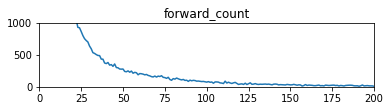

In [25]:
plt.subplot(3,1,1)
plt.axis([0,200,0,1000])
plt.plot(data1['forward_count'],data1['count'])
plt.title('forward_count')
#print (data1.info())

   like_count   count
0           0  917453
1           1  126172
2           2   55991
3           3   30530
4           4   19227


Text(0.5, 1.0, 'like_count')

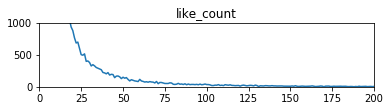

In [26]:
##点赞数为1，2，3.。。的微博个数
data2=data.groupby(['likes']).size()
data2=data2.reset_index()
data2.columns=['like_count','count']
print (data2.head())
plt.subplot(3,1,2)
plt.axis([0,200,0,1000])
plt.plot(data2['like_count'],data2['count'])
plt.title('like_count')

   comments_count   count
0               0  972026
1               1   83059
2               2   51624
3               3   27468
4               4   20262


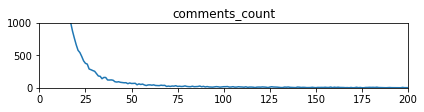

In [27]:
##评论数为1，2，3.。。的微博个数
data3=data.groupby(['comments']).size()
data3=data3.reset_index()
data3.columns=['comments_count','count']
print (data3.head())
plt.subplot(3,1,3)
plt.axis([0,200,0,1000])
plt.plot(data3['comments_count'],data3['count'])
plt.title('comments_count')
plt.tight_layout() 
plt.show()

In [28]:
data['forward_count']=data1['forward_count']
data['like_count']=data2['like_count']
data['comments_count']=data3['comments_count']

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(0.5, 1.0, 'weibo_count in weekday')

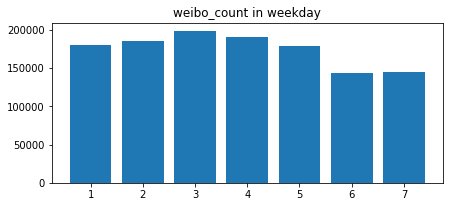

In [29]:
#发博时间
#周一-周日的发博次数
data=data.loc[:,['time_weekday','forward_count','like_count','comment_count']]
data1=data.groupby(['time_weekday']).size()
data1=data1.reset_index()
data1.columns=['time_weekday','count']
plt.figure(figsize=(7, 10), facecolor='#FFFFFF')
plt.subplot(3,1,1)
plt.bar(data1['time_weekday'],data1['count'])
plt.title('weibo_count in weekday') 

   time_weekday  forward_mean  comment_mean   like_mean
0             1   1218.457447           NaN  845.451064
1             2   1032.128571           NaN  802.360656
2             3   1367.670732           NaN  825.794118
3             4   1342.059211           NaN  889.895652
4             5   1394.134884           NaN  886.860465
5             6    919.925620           NaN  820.704762
6             7   1525.239521           NaN  804.165414


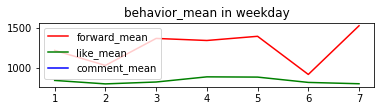

In [30]:
#周一-周日的发博的点赞中位数，平均值
data2=data.groupby(['time_weekday']).agg({'forward_count':np.mean,'comment_count':np.mean,'like_count':np.mean})
data2=data2.reset_index()
data2.columns=['time_weekday','forward_mean','comment_mean','like_mean']
print (data2)
plt.subplot(3,1,2)
plt.plot(data2['time_weekday'],data2['forward_mean'],label='forward_mean',color='red')
plt.plot(data2['time_weekday'],data2['like_mean'],label='like_mean',color='green')
plt.plot(data2['time_weekday'],data2['comment_mean'],label='comment_mean',color='blue')
plt.title('behavior_mean in weekday')  
plt.legend()

   forward_max  count
0          0.0  25297
1          1.0   4681
2          2.0   1663
3          3.0    875
4          4.0    509


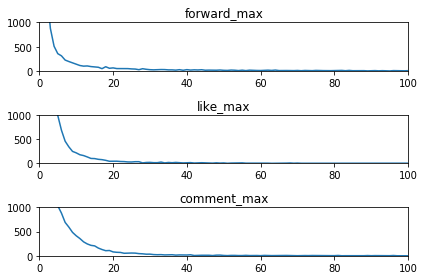

In [8]:
## 用户最大的点赞、评论、转发数的用户频数分布
data=data.drop_duplicates(['user_id'])
data=data.loc[:,['user_id','forward_max','comment_max','like_max']]
data1=data.groupby(['forward_max']).size()
data1=data1.reset_index()
data1.columns=['forward_max','count']
print (data1.head())
plt.subplot(3,1,1)
plt.axis([0,100,0,1000])
plt.plot(data1['forward_max'],data1['count'])
plt.title('forward_max')   

data2=data.groupby(['like_max']).size()
data2=data2.reset_index()
data2.columns=['like_max','count']
plt.subplot(3,1,2)
plt.axis([0,100,0,1000])
plt.plot(data2['like_max'],data2['count'])
plt.title('like_max')   

data3=data.groupby(['comment_max']).size()
data3=data3.reset_index()
data3.columns=['comment_max','count'] 
plt.subplot(3,1,3)
plt.axis([0,100,0,1000])
plt.plot(data3['comment_max'],data3['count'])
plt.title('comment_max')  
plt.tight_layout() 
plt.show()